5


# Feature selection of dataset for Deep Learning and applications in computer vision.
### Jesus Eduardo Ortiz Sandoval
### Ph.D Student
### Universidad Tecnica Federico Santa Maria
En este trabajo se pretende establecer unas bases teóricas para el estudio de los datasets sinteticos en aplicaciones de deep learning, el dataset sintetico es generado a partir de un software de renderizado 3D (Adobe MAX 3DS con licencia estudiantil). A continuación podemos observar una imágen generada desde el software de renderizado 3D.
![Papas pringles cebolla)](images/01.jpg)
Esta imágen guarda una relación muy parecida con una foto real, ya que se hace una composición del modelamiento 3D del producto con una serie de 3000 fondos de supermercados.  
En total se obtienen 25.000 imagenes desde el software antes de comenzar a hacer el pre-procesamiento de la información.
Lo primero que vamos a realizar es la extracción de caracteristicas de estas imagenes, cada imagen con fondo controlado tiene su misma imagen (ubicación, rotación, iluminación) con fondo blanco, esto para poder realizar la segmentación para generar el dataset de entrenamiento para la aplicación de visión por computador.

In [1]:
import shutil,os,re
from matplotlib import pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import sys
sys.path.append("..")
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import io
import pandas as pd
from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

Una vez que se tienen todas las bibliotecas que se pueden utilizar en nuestro programa el siguiente paso es extraer las caracteristicas de nuestra imagen respectiva, pero con fondo blanco.
![Papas pringles clasicas)](images/02.jpg)

160


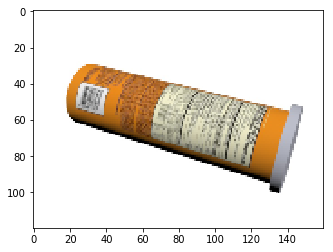

In [5]:
src = "./data" 
dst = "./data2"
for each in os.listdir(src):
    img = cv2.imread(os.path.join(src,each))
    img = cv2.resize(img,(160,120))
    cv2.imwrite(os.path.join(dst,each), img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    print (img.shape[1])
  
    

Ahora vamos a aplicar ORB para poder extraer los parametros para el etiquetado de las imagenes.


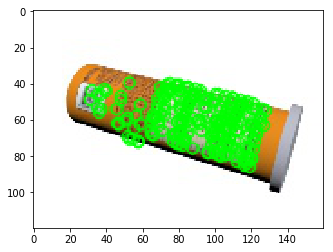

In [6]:
orb = cv2.ORB_create()
img = cv2.imread(os.path.join(dst,each))
img4=img
kp = orb.detect(img,None)
kp, des = orb.compute(img, kp)
img2 = cv2.drawKeypoints(img,kp,None, color=(0,255,0), flags=0)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

En este primer segmento hacemos una extraccion de caracteristicas rapida con ORB, se determina que la base y la tapa del elemento no se determinan como puntos relevantes, la mayoria de los puntos relevantes se enuentran en la etiqueta de los productos. Esta herramienta se le aplica a la imagen con el tamaño modificado, vamos a ejecutar el mismo algoritmo en la imagen de tamaño real.


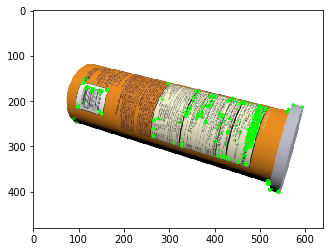

In [7]:
orb = cv2.ORB_create()
img = cv2.imread(os.path.join(src,each))
img3=img
kp = orb.detect(img,None)
kp, des = orb.compute(img, kp)
img2 = cv2.drawKeypoints(img,kp,None, color=(0,255,0), flags=0)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
pts = [p.pt for p in kp]


En la imagen de tamaño completo se determina que la etiqueta no es tan importante en las caracteristicas extraidas, pero si es relevante que detecta la tapa y la base, con este ejemplo podemos determinar facilmente los parametros *Xmin, Xmax, Ymin, Ymax* 

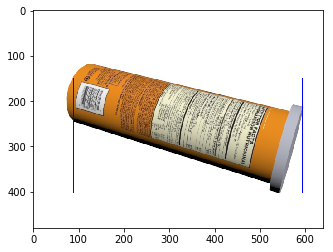

In [8]:
y=len(pts)
xmin=999
xmax=0
ymin=999
ymax=0
i=0
for i in range (0,y):
    x=pts[i]
    if (x[0]<=xmin):
        xmin=x[0]  
    if  (x[0]>=xmax):
        xmax=x[0]
i=0
for i in range (0,y):
    x=pts[i]
    if (x[1]<=ymin):
        ymin=x[1]  
    if  (x[1]>=ymax):
        ymax=x[1]
#PT1 xmin,ymin, PT2 xmax,ymax
cv2.rectangle(img3,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(255,0,0),1)
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))

En este caso hemos podido determinar el boundingbox adecuado para nuestro elemento y crearle su etiqueta correspondiente, es importante destacar la velocidad de ejecución del algoritmo (aca debemos meter el tiempo). Ahora con los puntos que se encuentran para la imágen de tamaño real, se procede a dividir en 4 estos mismos puntos y ver si coinciden con el resize creado en el algoritmo.

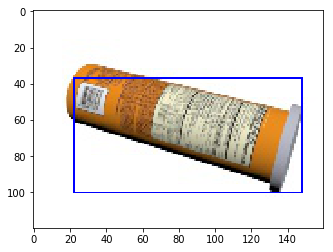

In [9]:
xmin1=xmin/4
ymin1=ymin/4
xmax1=xmax/4
ymax1=ymax/4
cv2.rectangle(img4,(int(xmin1),int(ymin1)),(int(xmax1),int(ymax1)),(255,0,0),1)
plt.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))

Como se mantiene la relación lineal de las imagenes y de los puntos de interes efectivamente el etiquetado funciona de una manera correcta en la imagen procesada en el punto anterior, ahora se procede a extraer todas las caracteristicas de las imagenes del set de datos y guardarlas en un archivo **CSV**.
Los parametros que se le entregan a este archivo son los siguientes.
1. Nombre de archivo
2. Width
3. Height
4. Clase
5. Ymin
6. Ymax
7. Xmin
8. Xmax

In [12]:

src = "./train" 
dst = "./train_resized"
for each in os.listdir(src):
    img = cv2.imread(os.path.join(src,each))
    img = cv2.resize(img,(160,120))
    cv2.imwrite(os.path.join(dst,each), img)
src1 = "./test" 
dst1 = "./test_resized"
for each in os.listdir(src1):
    img = cv2.imread(os.path.join(src1,each))
    img = cv2.resize(img,(160,120))
    cv2.imwrite(os.path.join(dst1,each), img)
test = './test'
train = './train'
#Lista vacia para incluir los ficheros
testFiles1 = []
trainFiles1 = []
#Lista con todos los ficheros del directorio:
testDir = os.walk(test) 
trainDir = os.walk(train)   #os.walk()Lista directorios y ficheros
#Crea una lista de los ficheros jpg que existen en el directorio y los incluye a la lista.
 
for root, dirs, files in testDir:
    for fichero in files:
        (nombreFichero, extension) = os.path.splitext(fichero)
        if(extension == ".jpg"):
            testFiles1.append(nombreFichero+".jpg")
            #print (nombreFichero+extension)
print ('LISTADO FINALIZADO')
print ("longitud de la lista = ", len(testFiles1))
        
            
f = open('test_labels.csv','w')
f.write('filename')
f.write(',')
f.write('width')
f.write(',')
f.write('height')
f.write(',')
f.write('class')
f.write(',')
f.write('ymin')
f.write(',')
f.write('ymax')
f.write(',')
f.write('xmin')
f.write(',')
f.write('xmax')
f.write('\n')
for j in range (0,len(files)):
# Create a list to keep all the words in file
    words = []
    mystr = ('cebolla','clasica','queso','bbq')
    img = cv2.imread(os.path.join(test,testFiles1[j]))
    width=img.shape[1]
    height=img.shape[0]
    f.write(testFiles1[j])
    f.write(',')
    f.write(str(int(width/4)))
    f.write(',')
    f.write(str(int(height/4)))
    f.write(',')
    m=testFiles1[j]
    m5 = m.find("CEBOLLA")
    if(m5>0):
        f.write(mystr[0])
    m5 = m.find("CLASICA")
    if(m5>0):
        f.write(mystr[1])
    m5 = m.find("QUESO")
    if(m5>0):
        f.write(mystr[2])
    m5 = m.find("BBQ")
    if(m5>0):
        f.write(mystr[3])
    f.write(',')
    orb = cv2.ORB_create()
    kp = orb.detect(img,None)
    kp, des = orb.compute(img, kp)
    #img2 = cv2.drawKeypoints(img,kp,None, color=(0,255,0), flags=0)
    #plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    pts = [p.pt for p in kp]
    xmin=999
    xmax=0
    ymin=999
    ymax=0
    y=len(pts)
    i=0
    for i in range (0,y):
        x=pts[i]
        if (x[0]<=xmin):
            xmin=x[0]  
        if  (x[0]>=xmax):
            xmax=x[0]
    i=0
    for i in range (0,y):
        x=pts[i]
        if (x[1]<=ymin):
            ymin=x[1]  
        if  (x[1]>=ymax):
            ymax=x[1]
    xmin1=xmin/4
    ymin1=ymin/4
    xmax1=xmax/4
    ymax1=ymax/4
    f.write(str(int(ymin1)))
    f.write(',')
    f.write(str(int(ymax1)))
    f.write(',')
    f.write(str(int(xmin1))) 
    f.write(',')
    f.write(str(int(xmax1)))
    f.write(',')    
    f.write('\n')
f.close()
for root, dirs, files in trainDir:
    for fichero in files:
        (nombreFichero, extension) = os.path.splitext(fichero)
        if(extension == ".jpg"):
            trainFiles1.append(nombreFichero+".jpg")
print ('LISTADO FINALIZADO')
print ("longitud de la lista = ", len(trainFiles1))
f = open('train_labels.csv','w')
f.write('filename')
f.write(',')
f.write('width')
f.write(',')
f.write('height')
f.write(',')
f.write('class')
f.write(',')
f.write('ymin')
f.write(',')
f.write('ymax')
f.write(',')
f.write('xmin')
f.write(',')
f.write('xmax')
f.write('\n')
for j in range (0,len(files)):
# Create a list to keep all the words in file
    words = []
    mystr = ('cebolla','clasica','queso','bbq')
    img = cv2.imread(os.path.join(train,trainFiles1[j]))
    width=img.shape[1]
    height=img.shape[0]
    f.write(trainFiles1[j])
    f.write(',')
    f.write(str(int(width/4)))
    f.write(',')
    f.write(str(int(height/4)))
    f.write(',')
    m=trainFiles1[j]
    m5 = m.find("CEBOLLA")
    if(m5>0):
        f.write(mystr[0])
    m5 = m.find("CLASICA")
    if(m5>0):
        f.write(mystr[1])
    m5 = m.find("QUESO")
    if(m5>0):
        f.write(mystr[2])
    m5 = m.find("BBQ")
    if(m5>0):
        f.write(mystr[3])
    f.write(',')
    orb = cv2.ORB_create()
    kp = orb.detect(img,None)
    kp, des = orb.compute(img, kp)
    #img2 = cv2.drawKeypoints(img,kp,None, color=(0,255,0), flags=0)
    #plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    pts = [p.pt for p in kp]
    xmin=999
    xmax=0
    ymin=999
    ymax=0
    i=0
    y=len(pts)
    for i in range (0,y):
        x=pts[i]
        if (x[0]<=xmin):
            xmin=x[0]  
        if  (x[0]>=xmax):
            xmax=x[0]
    i=0
    for i in range (0,y):
        x=pts[i]
        if (x[1]<=ymin):
            ymin=x[1]  
        if  (x[1]>=ymax):
            ymax=x[1]
    xmin1=xmin/4
    ymin1=ymin/4
    xmax1=xmax/4
    ymax1=ymax/4
    f.write(str(int(ymin1)))
    f.write(',')
    f.write(str(int(ymax1)))
    f.write(',')
    f.write(str(int(xmin1))) 
    f.write(',')
    f.write(str(int(xmax1)))
    f.write(',')    
    f.write('\n')
f.close()


LISTADO FINALIZADO
longitud de la lista =  600
LISTADO FINALIZADO
longitud de la lista =  2400


En este punto se generaron los dos archivos **CSV** para la generación del set de datos con la utilidad TFRECORDS.

In [19]:
%run -i generate_tfrecord.py --csv_input=images\train_labels.csv --image_dir=images\train --output_path=train.record

DuplicateFlagError: The flag 'csv_input' is defined twice. First from generate_tfrecord.py, Second from generate_tfrecord.py.  Description from first occurrence: Path to the CSV input

## Experimentos y Resultados.

En trabajos anteriores cuando se intentaba dictaminar cuales eran las características importantes de las imágenes se implementaban algoritmos sobre el **CSV** y a partir de allí se podía saber que características tenía más peso en la clasificación (en nuestro caso evaluaría cual/cuales de las siguientes características Width, Height, Clase, Ymin, Ymax, Xmin y Xmax tiene más impacto a la hora de clasificar). En nuestro trabajado, gracias a que tenemos completa autonomía para crear y manejar el dataset queremos ir en otra dirección, un paso más alla, queremos averiguar si alguna de las características intrínsecas de las imagenes nos ayudan en la clasificación.
Recordemos que la creación de nuestro dataset se basa primero en crear un modelo 3D a partir del software Adobe MAX 3DS, luego ocupando un script en ese software, rotando el modelo, cambiando la iluminación y los fondos se construye gran parte del dataset (luego entran a jugar un papel importante las GAN pero aquí no s el tema que se trata). 
Así pues se quiere ver si alguna de las características tales como la rotación o bien iluminación (de momento) ayudan a la clasificación. Es importante notar que no se trata de agregar estas características al  **CSV** y correr dichos algoritmos ya que esto no nos entregaría lo que buscamos. Nosotros buscamos saber si por ejemplo algun valor de orientación o bien iluminación ayuda más a clasificar que otros y luego poder construir un dataset balanceado como nos convenga tal que nos permita entrenar el clasificador con un menor numero de imagenes y/o un tiempo menor, aplicando aquí lo de bueno y breve dos veces bueno.
Para realizar dicho estudio se inicia construiendo 8 famílias, cada família con 3 clases diferentes(clasicas, cebolla, queso), 3000 imagenes de cada clase y 3000 de test (mezclando las clases en las de test) es decir cada modelo de cada família tiene 12000 imagenes. La gracia de dichas famílias es que todas las imagenes poseen fija una de las características intrinsecas antes mencionadas, en el caso  de la orientación se tiene de la siguiente forma: Imaginemos el círculo unidad, todo círculo posee 360 grados, así pues las imagenes de la primera família tendran 0 grados de rotación (la lata de pringles estara horizontalmente con la tapa hacia la derecha), la segunda família se le aplicara una rotación de tal manera que estara en 45 grados (con la tapa hacia arriba), la tercera estara en 90 grados, y asi sucesivamente, en 125, 180, 225, 270 y 305 grados, vease que aplicar otra rotación sería devolverse al estado inicial, es necesario comentar que para cada família se aplicaran pequeños errores en la rotación para ver cuan sensible es el modelo.

Una vez construidos dichos modelos se observara cuan bien o cuan mal clasifican las diferentes famílias, es decir se obsveraran los resultados de que classifique un conjunto de la misma família con la cual se ha entrenado (de manera lógica se esperaría que cada modelo clasificara mejor el conjunto con imagenes de la família con la que ha sido entrenado, se vera si eso es cierto), luego con conjuntos de cada una de las otras famílias y finalmente conjuntos de imagenes mezcladas de todas las famílias.
De esta forma se podrá concluir si bien existe alguna família que clasifique mejor que las otras, si las famílias espejo (por ejemplo las de 90 y 180, 45 y 125 etc) clasifican igual para así se pueder juntarse, si mezclar dos famílias ayuda a clasificar mejor etc

Para finalmente poder decidir si dichas características intrínsecas són importantes y así creear un dataset balanceado.

